In [ ]:
# Cell 1

from google.colab import drive
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Paths in your Drive
gdrive_base_dir     = '/content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4'
repo_dir            = os.path.join(gdrive_base_dir, 'stylegan2-ada-pytorch')
pretrained_model_dir= os.path.join(gdrive_base_dir, 'pretrained_models')
output_dir          = os.path.join(gdrive_base_dir, 'output')

# Create folders if missing
for d in (pretrained_model_dir, output_dir):
    os.makedirs(d, exist_ok=True)

# Clone StyleGAN2-ADA repo if not present
if not os.path.exists(repo_dir):
    !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git "{repo_dir}"

# Install deps
!pip install ninja wget librosa natsort moviepy scipy

# Add repo to path
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# Cell 1b (after cloning stylegan2-ada)
!git clone https://github.com/JCBrouwer/maua-stylegan2.git /content/maua-stylegan2

print("✅ Setup complete.")

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 10.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8117d2a5fd690f8bc2098db7c7d158ffb19ba8dbf18863a42111ab1a163484df
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Cloning into '/content/maua-stylegan2'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 1094 (delta 0), reused 0 (delta 0), pack-reused 1063 (from 1)
Receiving objects: 100% (1094/1094), 119.46 MiB | 22.69 MiB/s, done.
Resolving deltas: 100% (651/651), done.
✅ Setup complete.


✅ Model loaded: Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (af

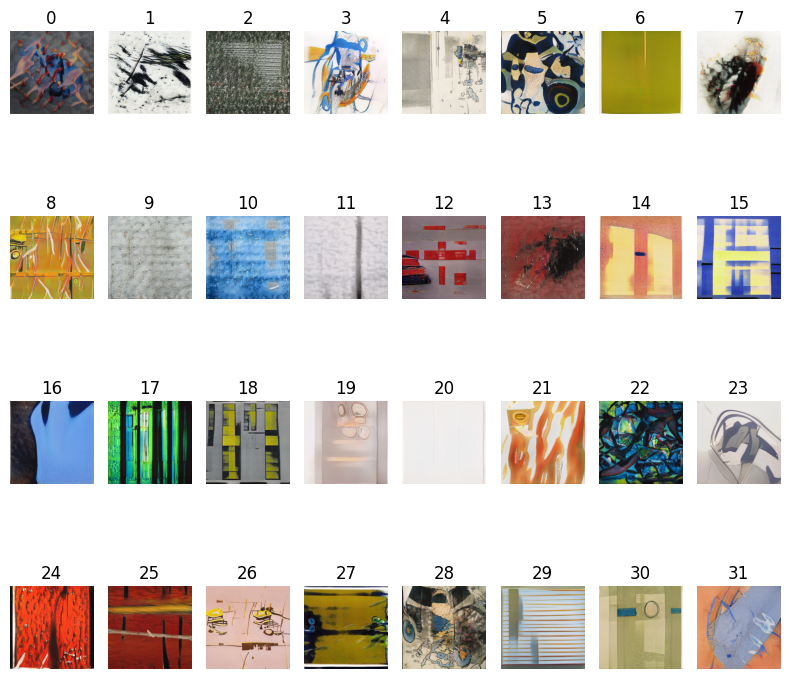

👉 Inspect the grid above, pick the indices of the latents you like (e.g. [2,5,9,13]), and store them for Cell 3.


In [ ]:
# Cell 2: Load StyleGAN2-ADA (no select_latents) and show a grid of samples

import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1) Add your local StyleGAN2-ADA to the path
repo_dir = '/content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/stylegan2-ada-pytorch'
sys.path.insert(0, repo_dir)

import dnnlib, legacy

# 2) Load the generator
model_path = os.path.join(pretrained_model_dir, 'ModernArt.pkl')  # update if needed
with open(model_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to('cuda')
print("✅ Model loaded:", G)

# 3) Sample a bank of z's and generate thumbnails
latent_dim = G.z_dim
num_candidates = 32
z_bank = torch.randn(num_candidates, latent_dim, device='cuda')
with torch.no_grad():
    imgs = G(z_bank, None, truncation_psi=1.0, noise_mode='const')  # (B,C,H,W)

# 4) Display them in a 4×4 grid
fig, axes = plt.subplots(4, 8, figsize=(8,8))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx].permute(1,2,0).cpu().numpy()
    img = (img * 127.5 + 128).clip(0,255).astype('uint8')
    ax.imshow(img)
    ax.set_title(f"{idx}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print("👉 Inspect the grid above, pick the indices of the latents you like (e.g. [2,5,9,13]), and store them for Cell 3.")

In [ ]:
# Cell 3: Pick your anchors from the displayed grid
chosen_idxs = [1, 7, 23, 26, 3, 24, 8, 15, 28, 31, 12, 10]                # ← replace with your picks
anchors_z   = z_bank[chosen_idxs].cpu()    # Tensor of shape (K, latent_dim)
print("Anchors z shape:", anchors_z.shape)

Anchors z shape: torch.Size([12, 512])


Saving Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp3 to Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp3


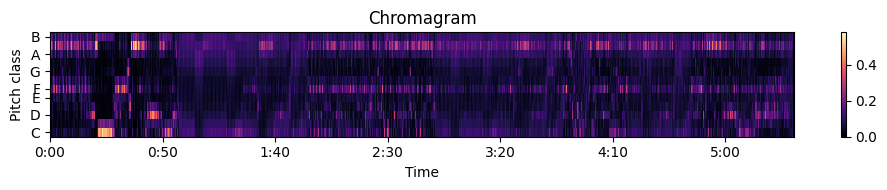

🔆 Cell 4: total_frames=9913


In [ ]:
# Cell 4: Upload audio & extract features

import librosa, librosa.display
from scipy.signal      import savgol_filter
from scipy.interpolate import interp1d
from google.colab      import files
import numpy as np
import matplotlib.pyplot as plt

# 1) Upload & load
uploaded       = files.upload()
audio_filename = list(uploaded.keys())[0]
y, sr          = librosa.load(audio_filename, sr=None)

# 2) Fast envelope: onset
onset_env   = librosa.onset.onset_strength(y=y, sr=sr)
onset_smooth= savgol_filter(onset_env, 51, 3)

# 3) Mid envelope: chromagram normalized
chroma      = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_norm = chroma / np.maximum(chroma.sum(axis=0, keepdims=True), 1e-6)

# 4) Slow envelope: rms
rms         = librosa.feature.rms(y=y)[0]

# 5) Visualize chroma
plt.figure(figsize=(10,2))
librosa.display.specshow(chroma_norm, y_axis='chroma', x_axis='time', sr=sr)
plt.title('Chromagram'); plt.colorbar(); plt.tight_layout(); plt.show()

# 6) Resample to frames
fps            = 30
duration       = librosa.get_duration(y=y, sr=sr)
total_frames   = int(duration * fps)
t_orig_on      = np.linspace(0,1,len(onset_smooth))
t_orig_chr     = np.linspace(0,1,chroma_norm.shape[1])
t_orig_rms     = np.linspace(0,1,len(rms))
t_target       = np.linspace(0,1,total_frames)

onset_res      = np.interp(t_target, t_orig_on, onset_smooth)
onset_res      = (onset_res - onset_res.min())/(onset_res.max()-onset_res.min())

chroma_res     = interp1d(t_orig_chr, chroma_norm, axis=1)(t_target)

rms_res        = np.interp(t_target, t_orig_rms, rms)
rms_res        = (rms_res - rms_res.min())/(rms_res.max()-rms_res.min())

print(f"🔆 Cell 4: total_frames={total_frames}")

In [ ]:
# Cell 5: Build final_latents via 3‑scale mixing in W+ space

import torch
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.ndimage     import gaussian_filter1d

latent_dim = G.z_dim
num_ws     = G.num_ws
w_dim      = G.w_dim
T          = total_frames

# 1) Map z anchors → W+ and collapse per‑layer to mean
with torch.no_grad():
    w_bank   = G.mapping(anchors_z.to('cuda'), None)  # (K, num_ws, w_dim)
anchors_w  = w_bank.mean(dim=1).cpu().numpy()       # (K, w_dim)

# 2) Long‑term spline through anchors (drift)
def drift_spline(anchors, sigma=3):
    K, C = anchors.shape
    pts  = np.vstack([anchors, anchors[0]])          # close loop
    t0   = np.linspace(0,1,K+1)
    t1   = np.linspace(0,1,T)
    arr  = np.stack([CubicSpline(t0, pts[:,d], bc_type='periodic')(t1)
                     for d in range(C)], axis=1)
    if sigma>0:
        arr = gaussian_filter1d(arr, sigma=sigma, axis=0)
    w   = torch.tensor(arr, dtype=torch.float32, device='cuda')
    return w.unsqueeze(1).repeat(1, num_ws, 1)       # (T,num_ws,w_dim)

wA  = drift_spline(anchors_w,    sigma=1)  # drift
wAp = drift_spline(anchors_w[::-1],sigma=1)  # reverse

# 3) Mid‑level chroma spline
palette = torch.randn(chroma_res.shape[0], latent_dim, device='cuda')
chroma_np = np.dot(chroma_res.T, palette.cpu().numpy())  # (T, latent_dim)
chroma_sm = gaussian_filter1d(chroma_np, sigma=1, axis=0)
wC       = torch.tensor(chroma_sm, dtype=torch.float32, device='cuda') \
               .unsqueeze(1).repeat(1, num_ws, 1)

# 4) Fine pulses micro‑loop (faster)
wPulse = drift_spline(anchors_w, sigma=1)  # reuse drift_spline for loop

# 5) Layer groups
coarse = list(range(0, 4))
mid    = list(range(4,8))
fine   = list(range(8,num_ws))

# 6) Smooth envelopes
rms_s   = gaussian_filter1d(rms_res, sigma=3)
ch_s    = gaussian_filter1d(chroma_res.mean(axis=0), sigma=1)
on_s    = onset_res  # raw

# 7) Assemble
all_w = []
for i in range(T):
    base = wA[i].clone()
    c    = rms_s[i]
    m    = ch_s[i]
    f    = min(on_s[i]*3,1.0)
    # coarse: A→A’ by rms
    for l in coarse:
        base[l] = wA[i,l]*(1-c) + wAp[i,l]*c
    # mid : base→chroma
    for l in mid:
        base[l] = base[l]*(1-m) + wC[i,l]*m
    # fine: pulses
    for l in fine:
        base[l] = base[l]*(1-f) + wPulse[i,l]*f
    all_w.append(base)

stack = torch.stack(all_w, dim=0)               # (T,num_ws,w_dim)
flat  = stack.cpu().numpy().reshape(T, -1)
flatS = gaussian_filter1d(flat, sigma=1, axis=0)  # tiny blur
final_latents = torch.tensor(flatS, dtype=torch.float32, device='cuda') \
                   .reshape(T, num_ws, w_dim)

print("🔆 Cell 5: final_latents ready.")

🔆 Cell 5: final_latents ready.


In [ ]:
# Cell 6: 10 s Preview at an arbitrary timepoint with jitter + noise bursts

import torch
from moviepy.editor import ImageSequenceClip, AudioFileClip
from IPython.display   import HTML
from tqdm.notebook     import tqdm
import numpy as np

# ─── USER PARAM: where should the preview start? ─────────────────────────────────
preview_start_sec = 50    # <-- change this to any time (in seconds) you like
preview_duration  = 15    # keep this at 10 s (or adjust)
# ────────────────────────────────────────────────────────────────────────────────

fps        = 30
start      = int(preview_start_sec * fps)
end        = min(total_frames, start + int(preview_duration * fps))

frames = []
fine_layers = list(range(8, G.num_ws))

for i in tqdm(range(start, end), desc=f"Building preview @ {preview_start_sec}s"):
    # 1) get latent + fine-layer jitter
    ws = final_latents[i:i+1].clone()
    j  = min(onset_res[i] * 0.02, 0.06)
    ws[:, fine_layers, :] += torch.randn_like(ws[:, fine_layers, :]) * j

    # 2) onset‑driven spike noise maps
    noise_kwargs = {}
    for name, buf in G.synthesis.named_buffers():
        if not name.startswith('noise'):
            continue
        strength = onset_res[i] * 0.05
        noise_kwargs[name] = torch.randn_like(buf) * strength

    # 3) synthesize
    with torch.no_grad():
        img = G.synthesis(ws, noise_mode='const', **noise_kwargs)[0]

    # 4) to uint8 HWC
    arr = (img.cpu().numpy() * 127.5 + 128).clip(0,255).astype('uint8')
    frames.append(arr.transpose(1,2,0))

# render and display
clip = ImageSequenceClip(frames, fps=fps)
clip = clip.set_audio(AudioFileClip(audio_filename)
                     .subclip(preview_start_sec, preview_start_sec + preview_duration))
clip.ipython_display(width=480, autoplay=True)

Building preview @ 50s:   0%|          | 0/450 [00:00<?, ?it/s]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
# Cell 7: Render all frames to song‑named frames folder

import os, shutil, PIL
from tqdm.notebook import tqdm
import torch

audio_base = os.path.splitext(audio_filename)[0]
frame_dir  = os.path.join(output_dir, audio_base, "frames")
if os.path.exists(frame_dir): shutil.rmtree(frame_dir)
os.makedirs(frame_dir, exist_ok=True)

fine_layers = list(range(8, G.num_ws))
for i in tqdm(range(total_frames), desc="Rendering"):
    ws = final_latents[i:i+1].clone()
    j  = min(onset_res[i]*0.02, 0.06)
    ws[:,fine_layers,:] += torch.randn_like(ws[:,fine_layers,:])*j

    noise_kwargs = {}
    for name, buf in G.synthesis.named_buffers():
        if not name.startswith('noise'): continue
        strength = onset_res[i]*0.5
        noise_kwargs[name] = torch.randn_like(buf)*strength

    with torch.no_grad():
        img = G.synthesis(ws, noise_mode='const', **noise_kwargs)[0]
    arr = (img.cpu().numpy()*127.5+128).clip(0,255).astype('uint8')
    PIL.Image.fromarray(arr.transpose(1,2,0)).save(
        os.path.join(frame_dir, f"frame_{i:06d}.png")
    )

print("✅ Done – frames in", frame_dir)

Rendering:   0%|          | 0/9913 [00:00<?, ?it/s]

✅ Done – frames in /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/frames


In [ ]:
# Cell 8: Un‑sharp mask
import os, cv2
from tqdm.notebook import tqdm

audio_base   = os.path.splitext(audio_filename)[0]
raw_dir      = os.path.join(output_dir, audio_base, "frames")
sharp_dir    = os.path.join(output_dir, audio_base, "frames_sharp")
upscaled_dir = os.path.join(output_dir, audio_base, "frames_2048")

os.makedirs(sharp_dir, exist_ok=True)
os.makedirs(upscaled_dir, exist_ok=True)

# sharpening params|
amount, radius, threshold = 1.5, 3, 5

for fname in tqdm(sorted(os.listdir(raw_dir)), desc="Sharpening frames"):
    if not fname.lower().endswith(".png"):
        continue
    img = cv2.imread(os.path.join(raw_dir, fname))
    blurred = cv2.GaussianBlur(img, (0,0), sigmaX=radius)
    mask    = cv2.subtract(img, blurred)
    lowc    = cv2.absdiff(mask, 0) < threshold
    sharp   = cv2.addWeighted(img, 1+amount, blurred, -amount, 0)
    sharp[lowc] = img[lowc]
    cv2.imwrite(os.path.join(sharp_dir, fname), sharp)

print("✅ Sharpened frames in", sharp_dir)

Sharpening frames:   0%|          | 0/9913 [00:00<?, ?it/s]

✅ Sharpened frames in /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/frames_sharp


In [ ]:
# Cell 9: Assemble & write MP4 from sharpened frames

import os
import glob
import librosa
from natsort import natsorted
from moviepy.editor import ImageSequenceClip, AudioFileClip
from moviepy.video.fx.all import crop

# 1) Point to your sharpened frames folder
audio_base        = os.path.splitext(audio_filename)[0]
sharp_dir         = os.path.join(output_dir, audio_base, "frames_sharp")
pattern           = os.path.join(sharp_dir, "*.png")
frame_files       = natsorted(glob.glob(pattern))

if not frame_files:
    raise ValueError(f"No frames found in {sharp_dir}")

# 2) Parameters
frames_per_second = 30  # match Cell 4
duration_seconds  = librosa.get_duration(filename=audio_filename)

# 3) Load into MoviePy
clip = ImageSequenceClip(frame_files, fps=frames_per_second)

# 5) Attach audio
audio_clip = AudioFileClip(audio_filename).subclip(0, duration_seconds)
final_clip = clip.set_audio(audio_clip)

# 6) Write clips to outpur dir
output_path = os.path.join(output_dir, audio_base, f"{audio_base}.mp4")
os.makedirs(os.path.dirname(output_path), exist_ok=True)

final_clip.write_videofile(
    output_path,
    codec="libx264",
    audio_codec="aac",
    fps=frames_per_second,
    ffmpeg_params=["-crf","15","-preset","slow","-pix_fmt","yuv444p"]

)

print("✅ Final 16∶9 video saved to", output_path)

Moviepy - Building video /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp4.
MoviePy - Writing audio in Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp4
✅ Final 16∶9 video saved to /content/drive/MyDrive/AI_Art/StyleGAN2_Reactive_V4/output/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix)/Ben Böhmer feat. Gordi - Slow Wave (The Blaze Remix).mp4
